In [1]:
import glob

import numpy as np
from cfgrib.xarray_store import open_dataset
import xarray as xr
import h5py

import matplotlib.pyplot as plt
import cartopy.crs as ccrs


import gcsfs
import load_data 
import importlib
importlib.reload(load_data)
from load_data import load_and_regrid_data, get_lon_lat_reg, get_ai_models, get_cGAN, get_IMERG_year


ERROR 1: PROJ: proj_create_from_database: Open of /home/n/nath/nobackup/anaconda3/envs/ai-models/share/proj failed


In [2]:
models = ['graphcast', 'fuxi']

df_all = []

for year in [2021,2022,2023]:
    if year>2022:
        df_all.append(load_and_regrid_data(models, year, era5=False, true_netcdf=False))
    else:
        df_all.append(load_and_regrid_data(models, year, era5=False, true_netcdf=True))

df_ai = xr.concat([df[0] for df in df_all],dim='time',coords='minimal')
df_IMERG = xr.concat([df[1] for df in df_all],dim='time')

100%|███████████████████████████████████████████████████████████████████████| 366/366 [24:03<00:00,  3.94s/it]


Could not find any IMERG data for,  2024-01-01T00:00:00.000000000
(366, 384, 352)
Regridding data for models: ['graphcast', 'fuxi']  at year: 2023 (384,) (352,)


In [10]:
df_IMERG = xr.concat([get_IMERG_year(2018), get_IMERG_year(2019), get_IMERG_year(2020), df_IMERG], dim='time')



In [75]:
import sys
sys.path.insert(1, '/home/n/nath/aimodels_exp/')
import ar_generator 

import importlib
importlib.reload(ar_generator)

ar = ar_generator.model()
ar.fit(df_IMERG.sel({'time':np.arange('2018-01-01','2022-01-01',np.timedelta64(1,'D'),dtype='datetime64[ns]')}))



Performing fit for AR(1) coefficients and GPD parameters
Extracted seasonal cycle
Extracted AR(1) coefficients and covariance matrix and all done in ---- 192.30843830108643 s----


In [ ]:
predictions = []

for date in np.arange('2023-01-01','2024-01-01',np.timedelta64(1,'D'),dtype='datetime64[ns]'):
    predictions.append(ar.predict_xr(50, date, 1))

predictions = xr.concat(predictions, dim='time')


Generated 50 emulations of length 1 in ---- 38.213056325912476 s----
Generated 50 emulations of length 1 in ---- 40.02934288978577 s----
Generated 50 emulations of length 1 in ---- 38.07845067977905 s----
Generated 50 emulations of length 1 in ---- 37.17117261886597 s----
Generated 50 emulations of length 1 in ---- 37.369354248046875 s----
Generated 50 emulations of length 1 in ---- 37.420337200164795 s----
Generated 50 emulations of length 1 in ---- 37.96463346481323 s----
Generated 50 emulations of length 1 in ---- 37.737712144851685 s----
Generated 50 emulations of length 1 in ---- 38.97721862792969 s----
Generated 50 emulations of length 1 in ---- 38.207427740097046 s----
Generated 50 emulations of length 1 in ---- 40.556429862976074 s----
Generated 50 emulations of length 1 in ---- 40.20552659034729 s----
Generated 50 emulations of length 1 in ---- 38.17856955528259 s----
Generated 50 emulations of length 1 in ---- 37.919079065322876 s----
Generated 50 emulations of length 1 in --

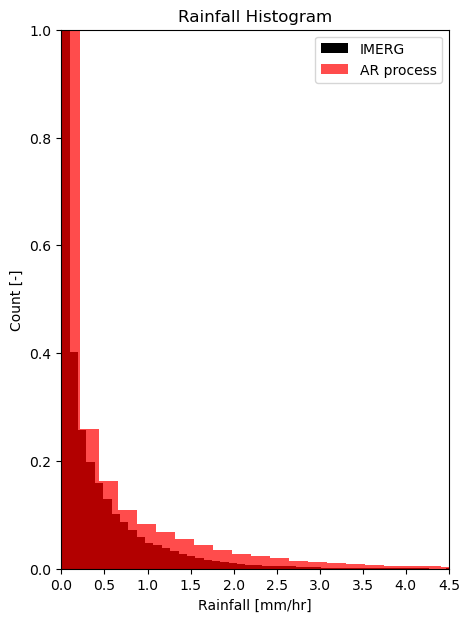

In [72]:

fs_title=16

fig=plt.figure(figsize=(5,7))
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'mathtext.default':'regular'}) 
plt.rcParams.update({'mathtext.default':'it'}) 


ax = fig.add_subplot(1,1,1)

ax.hist(df_IMERG.sel({'time':np.arange('2020-03-01','2020-03-04',np.timedelta64(1,'D'),dtype='datetime64[ns]')}).precipitation.values.flatten(),bins=100, color='k', label='IMERG', density=True)
ax.hist(predictions.precipitation.values.flatten(),bins=100, color='r', alpha=0.7, density=True, label='AR process')

ax.set_xlim(0,4.5)
ax.set_ylim(0,1)

ax.set_xlabel('Rainfall [mm/hr]')
ax.set_ylabel('Count [-]')

plt.title('Rainfall Histogram')

plt.legend()      